<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/IntroAIMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dense NN on MNIST
The following code is a simplified example of a model training and testing on MNIST. The objective is to improve this model, somehow, to be better.

# Setup

In [ ]:
#Downloading the MNIST training and testing data. There's a lot of ways to
#get this data, this is just one that I found on Google.
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 29771556.88it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1285668.58it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8261726.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6700854.30it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Exploring the Data

In [ ]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [ ]:
#printing the shape of the data.

#60,000 labled training exampls of 28x28 images.
print(train_data.data.shape)

#60,000 labels, each one corresponding to an image.
print(train_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


tensor(3)


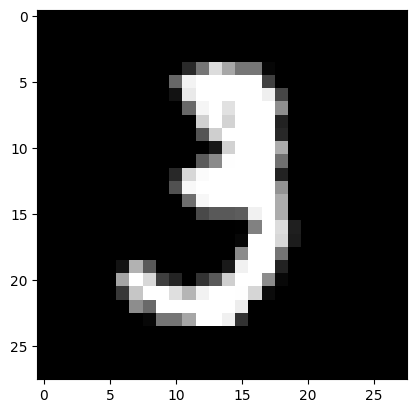

In [ ]:
#rendering a particular example
import matplotlib.pyplot as plt
i = 10
plt.imshow(train_data.data[i], cmap='gray')
print(train_data.targets[i])
plt.show()

In [ ]:
import torch
torch.set_printoptions(linewidth=200)
i = 10
print(train_data.data[i])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219, 166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254, 254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18, 232, 254, 254, 254, 254, 254, 238,  

# Defining the Model
this is kind of clever, I found this while Googling.
instead of needing to call each layer, like I did
```
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.dense1 = nn.Linear(784,10)
        self.dense2 = nn.Linear(10,10)
        ...

    def forward(self, x):
        x = torch.flatten(x)
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        ...
        return x
```

you can use `nn.Sequential` to wrap everything up into a sequence that just needs to be called once. Saves on some code, and easier to develop on.

Also, based on this article:

https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc

apparently I didn't need to put softmax at the end of the model. Maybe that's what was going wrong.

In [ ]:
from torch import nn
import torch

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

#defining the model and printing it.
#it gets re-defined later just so I don't accidentally train the
#same model a few times.
model = MNISTModel()
print(model)

MNISTModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (activation2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


# Training

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

model = MNISTModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

losses = []

for i, (x, y) in tqdm(enumerate(zip(train_data.data, train_data.targets))):

    #putting the input to the model onto the device
    x = x.type(torch.float32)

    #having
    y_pred = model.forward(x)

    #re-formatting the output to instead of 0-10 it's [1,0,0,0,0,0,0,0,0,0] - [0,0,0,0,0,0,0,0,0,1]
    y = F.one_hot(y,10).type(torch.float32)

    loss = loss_fn(y_pred, y)

    # Backward pass (updating model based on gradients)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #keeping track of loss
    losses.append(float(loss))

60000it [01:28, 681.11it/s]


0


60000it [01:29, 673.74it/s]


1


60000it [01:28, 680.39it/s]


2


60000it [01:29, 671.06it/s]


3


15850it [00:23, 663.92it/s]


KeyboardInterrupt: 

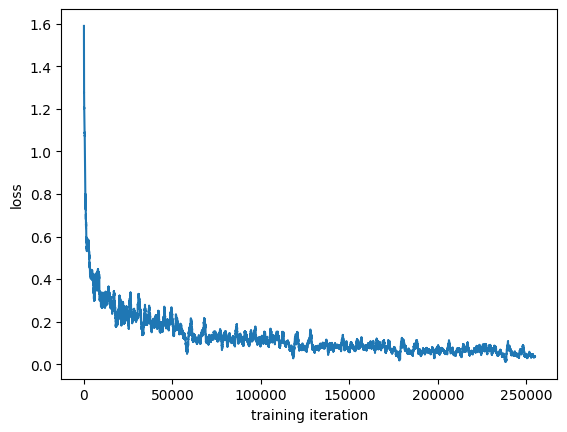

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#if we just plot the noise of individual samples we'll get a very sporadic line'
#this smooths out the trend of our data.
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

plt.plot(moving_avg(losses, 1000))
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()

# Testing
now that our model has trained, we can apply it to our test data to see how good it is.

In [ ]:
num_true = 0
test_quant = 0

for (x_test, y_test) in zip(test_data.data, test_data.targets):
    #running test example through model
    y_pred_test = model(x_test.type(torch.float32))

    #getting predicted value (highest value)
    y_pred_test = torch.argmax(y_pred_test)

    # print('---')
    # print(y_test)
    # print(y_pred_test)

    #checking to see if the right value was predicted
    if bool(y_pred_test == y_test):
        num_true += 1
    test_quant += 1

print(f'Accuracy %:')
print((num_true/test_quant)*100)

Accuracy %:
96.69
